In [2]:
import numpy as np
import pandas as pd
import configparser
config = configparser.ConfigParser()

In [4]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [6]:
config.read("../../env.ini")
data_home = config['DEFAULT']['data_home']
local_lib = config['DEFAULT']['local_lib']

In [8]:
!ls -l {data_home}

total 89664
-rw-r--r--@ 1 Samantha  staff   1752309 Jan 27 17:42 austen-persuasion.csv
drwxr-xr-x@ 9 Samantha  staff       288 Jan 16 08:52 gutenberg
-rw-r--r--@ 1 Samantha  staff  43681675 Feb 28 14:01 novels-CORPUS.csv
-rw-r--r--@ 1 Samantha  staff       421 Feb 28 14:00 novels-LIB.csv
-rw-r--r--@ 1 Samantha  staff    465627 Jan 20 15:27 pg42324.txt
drwxr-xr-x@ 7 Samantha  staff       224 May  1 22:04 woolf


In [10]:
data_directory = f"{data_home}/woolf"
OHCO = ['book_id','chap_num', 'para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)
bag = 'CHAPS'

In [12]:
LIB = pd.read_csv(f"woolf-LIB.csv").set_index('book_id')
TOKEN = pd.read_csv(f'woolf-CORPUS.csv').set_index(OHCO).dropna()
VOCAB = pd.read_csv(f'woolf-VOCAB.csv').set_index('term_str').dropna()
BOW = pd.read_csv(f'woolf-BOW-{bag}.csv').set_index(bags[bag]+['term_str'])
DTCM = pd.read_csv(f'woolf-DTCM-{bag}.csv').set_index(bags[bag]) 
TFIDF = pd.read_csv(f'woolf-TFIDF-{bag}.csv').set_index(bags[bag])
TFIDF_L2 = pd.read_csv(f'woolf-TFIDF_L2-{bag}.csv').set_index(bags[bag])

In [14]:
from scipy.linalg import norm
from scipy.linalg import eigh
import plotly_express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

## PCA

In [16]:
def gen_PCA(X, k, norm_docs=True, center_by_mean=False, center_by_variance=False):
    '''
    This function takes a document term count matrix as input and returns three dataframes: the term-component matrix, the document-component matrix, and the component information table.

    PARAMETERS
    X: the input matrix
    k: number of components to generate
    norm_docs: normalize doc vector lengths; True or False
    center_by_mean: True or False
    center_by_variance: True or False

    RETURNS
    LOADINGS: term-component matrix
    DCM: document-component matrix
    COMPINF: component information table
    '''

    if norm_docs:
        norms = norm(X, 2, axis=1)
        norms[norms == 0] = 1  # Avoid division by zero        
        X = (X.T / norms).T

    X = X.dropna() # remove nulls

    if center_by_variance:
        X = (X - X.mean()) / X.std()
    elif center_by_mean:
        X = X - X.mean()

    # Compute covariance or correlation matrix
    if center_by_mean and center_by_variance:
        COV = np.corrcoef(X.to_numpy(), rowvar=False)  # Correlation matrix
        COV = pd.DataFrame(COV, index=X.columns, columns=X.columns)
    elif center_by_mean and not center_by_variance:
        COV = X.cov()  # Covariance matrix
    elif not center_by_mean and center_by_variance:
        COV = np.corrcoef(X.to_numpy(), rowvar=False)  # Correlation matrix
        COV = pd.DataFrame(COV, index=X.columns, columns=X.columns)
    else:
        COV = X.T.dot(X) / (X.shape[0] - 1)  # Uncentered covariance

    # Decompose the matrix
    eig_vals, eig_vecs = eigh(COV)
    idx = np.argsort(eig_vals)[::-1]  # Sort eigenvalues in descending order
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]

    # Convert eigen data to dataframes
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'

    # Combine eigenvalues and eigenvectors
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

    # Pick top k components (COMPS)
    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(k).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'

    # See projected components onto vocabulary (LOADINGS)
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'

    # Component information table
    top_terms = []
    for i in range(k):
        for j in [0, 1]:
            comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(k).index.to_list())
            top_terms.append((f"PC{i}", j, comp_str))
    COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
    COMP_GLOSS.index.name = 'comp_id'
    COMP_GLOSS.columns = COMP_GLOSS.columns.droplevel(0) 
    COMP_GLOSS = COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})
    COMPINF = COMP_GLOSS

    # Project docs onto components
    DCM = X.dot(LOADINGS)
    DCM = DCM.join(LIB[['raw_title','book_len','n_chaps','date','n_chars','woolf_age','prot_sex']], on='book_id')
    DCM['doc'] = DCM.apply(lambda x: f"{x['raw_title']} {str(x.name[1]).zfill(2)}", 1)

    return LOADINGS, DCM, COMPINF


In [18]:
loadings, dcm, compinf = gen_PCA(X=TFIDF_L2, k=10, norm_docs=True, center_by_mean=True, center_by_variance=True)

In [20]:
compinf

1,pos,neg
comp_id,,
PC0,that but not was had her upon ive person you,jacob s t don flanders durrant betty bonamy wh...
PC1,katharine katharines ralph statement denham be...,rachel women really like villa people helen se...
PC2,married friends often imagine interested used ...,region darkness globe swam recollection blinds...
PC3,poet among mothers poets task books keeping ba...,voice know you am wanted couldnt continued int...
PC4,irritated free except heat dry supposing hirst...,quite poor Unnamed: 1151 really dear has table...
PC5,filled faster path wound miles knowledge speec...,obscure region swam omnibus lamps windows wine...
PC6,vision page head do leave exclaimed thats firm...,lake bag gardens accept settled discuss force ...
PC7,occasional because gibbon singing generally vi...,spanish centre few unless glasses length neare...
PC8,mad india cabs peter motor walsh agitation fal...,fire piece wont added spanish consider reflect...


In [22]:
loadings

pc_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
katharine,0.040011,0.066534,0.004729,0.024588,-0.017139,-0.002975,0.038392,-0.001781,-0.000898,-0.021277
rachel,0.018603,-0.085255,0.013701,-0.017461,0.012738,-0.005419,0.002903,0.014437,-0.017411,-0.005304
s,-0.053933,0.015591,-0.009280,0.005089,0.007634,0.011806,-0.007646,-0.006668,-0.014754,-0.005276
mary,0.029296,0.043636,-0.003334,-0.006418,0.003760,0.005688,0.027783,-0.036532,-0.007557,0.022235
jacob,-0.054135,0.015958,-0.008699,0.004152,0.005779,0.011583,-0.008212,-0.006530,-0.014328,-0.003835
...,...,...,...,...,...,...,...,...,...,...
eighteenth,-0.020958,-0.002859,-0.010505,0.009466,0.015987,0.033651,0.009955,0.016794,0.015271,0.039654
drink,-0.011016,0.004178,0.008632,-0.014524,-0.014025,0.012223,0.006991,-0.003950,-0.001080,0.007999
sentimental,-0.003438,0.000126,0.020235,0.020312,-0.009038,-0.033034,-0.015392,0.009312,0.050537,-0.008785


In [24]:
dcm

PC0        PC1       PC2       PC3       PC4  \
book_id chap_num                                                       
1       1         -1.579532 -10.114831 -3.889647  1.290638 -3.114222   
        2          5.618762 -15.346727  1.478937  3.983658 -4.923074   
        3         -3.155949  -5.095130  7.138909 -4.183797 -4.559144   
        4          0.308219  -4.480020  3.745316 -4.808001 -3.366109   
        5         -3.273038  -9.326549 -0.888930 -9.753351 -4.244162   
...                     ...        ...       ...       ...       ...   
4       4        -12.029837   2.519554 -1.650666 -4.170762 -2.893737   
        5        -18.843393   7.454705 -2.015735 -0.455140  4.898524   
        6        -12.102701   2.876373  4.939435 -4.665702  0.986317   
        7         -5.068335  -2.362338  3.617457 -1.193412 -2.639686   
        8        -12.330378   2.741812  5.180300 -2.980459 -1.076794   

                       PC5       PC6       PC7        PC8        PC9  \
book_id chap_num                                                       
1       1        -1.975822  0.870817 -4.443228   1.674313  -3.057033   
        2        -7.594459 -4.924114  0.387149   4.961678   3.116254   
        3         0.410340  0.105372  1.735025  -1.308407  -1.591757   
        4        -0.197625  2.334511  1.557431  -0.947005  -1.110994   
        5         2.843397  0.349529  2.453320   0.844519 -10.814969   
...                    ...       ...       ...        ...        ...   
4       4        -6.218422 -9.684693  0.646134  16.644121   4.097456   
        5         0.587362  0.535684  1.366645  -1.697780  -2.420247   
        6         1.145046 -3.555122  0.254456   8.381854   0.844246   
        7        -4.125601 -7.100321 -0.338648   9.746048   3.286848   
        8        -1.434265 -4.368773  0.989078   6.002201   2.533196   

                       raw_title  book_len  n_chaps  date  n_chars  woolf_age  \
book_id chap_num                                                                
1       1         THE VOYAGE OUT    138107       27  1915   612493         33   
        2         THE VOYAGE OUT    138107       27  1915   612493         33   
        3         THE VOYAGE OUT    138107       27  1915   612493         33   
        4         THE VOYAGE OUT    138107       27  1915   612493         33   
        5         THE VOYAGE OUT    138107       27  1915   612493         33   
...                          ...       ...      ...   ...      ...        ...   
4       4           MRS DALLOWAY     64489        8  1925   287737         43   
        5           MRS DALLOWAY     64489        8  1925   287737         43   
        6           MRS DALLOWAY     64489        8  1925   287737         43   
        7           MRS DALLOWAY     64489        8  1925   287737         43   
        8           MRS DALLOWAY     64489        8  1925   287737         43   

                 prot_sex                doc  
book_id chap_num                              
1       1               f  THE VOYAGE OUT 01  
        2               f  THE VOYAGE OUT 02  
        3               f  THE VOYAGE OUT 03  
        4               f  THE VOYAGE OUT 04  
        5               f  THE VOYAGE OUT 05  
...                   ...                ...  
4       4               f    MRS DALLOWAY 04  
        5               f    MRS DALLOWAY 05  
        6               f    MRS DALLOWAY 06  
        7               f    MRS DALLOWAY 07  
        8               f    MRS DALLOWAY 08  

[83 rows x 18 columns]

### SAVE TABLES TO FILES

In [26]:
loadings.to_csv('woolf-PCA_LOADINGS.csv', index=True, header=True)
dcm.to_csv('woolf-PCA_DCM.csv', index=True, header=True)
compinf.to_csv('woolf-PCA_COMPINF.csv', index=True, header=True)

In [28]:
LIB

,source_file_path,raw_title,book_len,n_chaps,date,n_chars,woolf_age,prot_sex
book_id,,,,,,,,
1,/Users/Samantha/Desktop/MSDS/DS5001/data/woolf...,THE VOYAGE OUT,138107,27,1915,612493,33,f
2,/Users/Samantha/Desktop/MSDS/DS5001/data/woolf...,NIGHT AND DAY,168196,34,1919,760337,37,f
3,/Users/Samantha/Desktop/MSDS/DS5001/data/woolf...,JACOBS ROOM,56548,14,1922,250699,40,m
4,/Users/Samantha/Desktop/MSDS/DS5001/data/woolf...,MRS DALLOWAY,64489,8,1925,287737,43,f


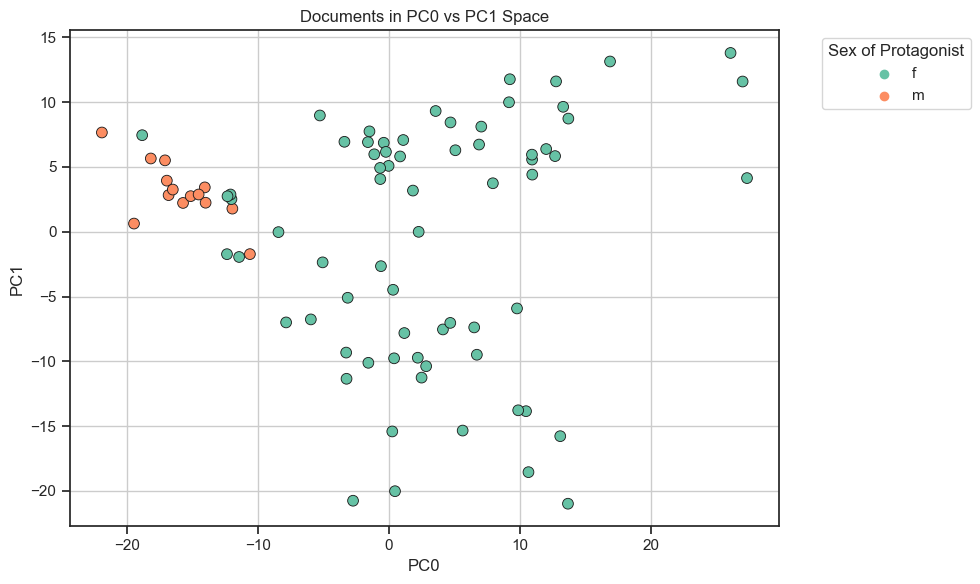

In [30]:
# 8.4 PCA visualization 1

import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplot of documents on PC0 vs PC1
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=dcm.reset_index(),
    x='PC0',
    y='PC1',
    hue='prot_sex',
    palette='Set2',
    s=60,
    edgecolor='k')
plt.title("Documents in PC0 vs PC1 Space")
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.legend(title='Sex of Protagonist', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_vis_1a.png", dpi=300)
plt.show()

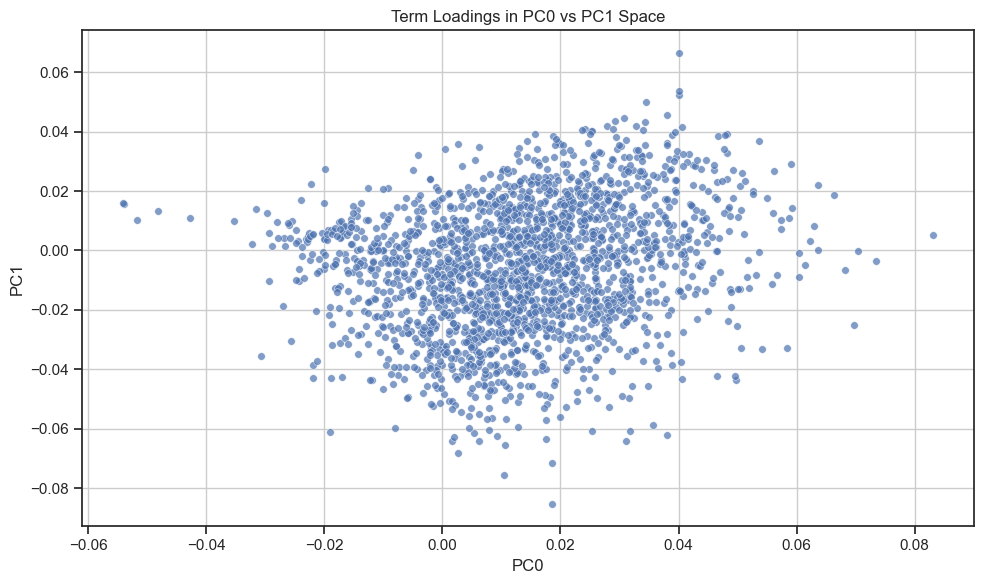

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=loadings.reset_index(),
    x='PC0',
    y='PC1',
    alpha=0.7,
    s=30)
plt.title("Term Loadings in PC0 vs PC1 Space")
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_vis_1b.png", dpi=300)
plt.show()

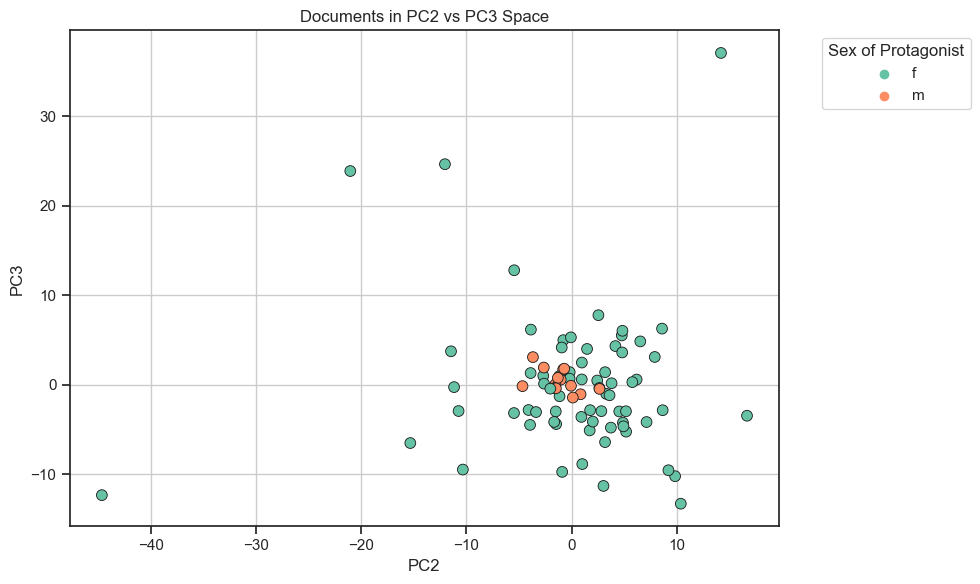

In [34]:
# 8.5 PCA visualization 2

# Scatterplot of documents on PC2 vs PC3
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=dcm.reset_index(),
    x='PC2',
    y='PC3',
    hue='prot_sex',
    palette='Set2',
    s=60,
    edgecolor='k')
plt.title("Documents in PC2 vs PC3 Space")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.legend(title='Sex of Protagonist', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_vis_2a.png", dpi=300)
plt.show()

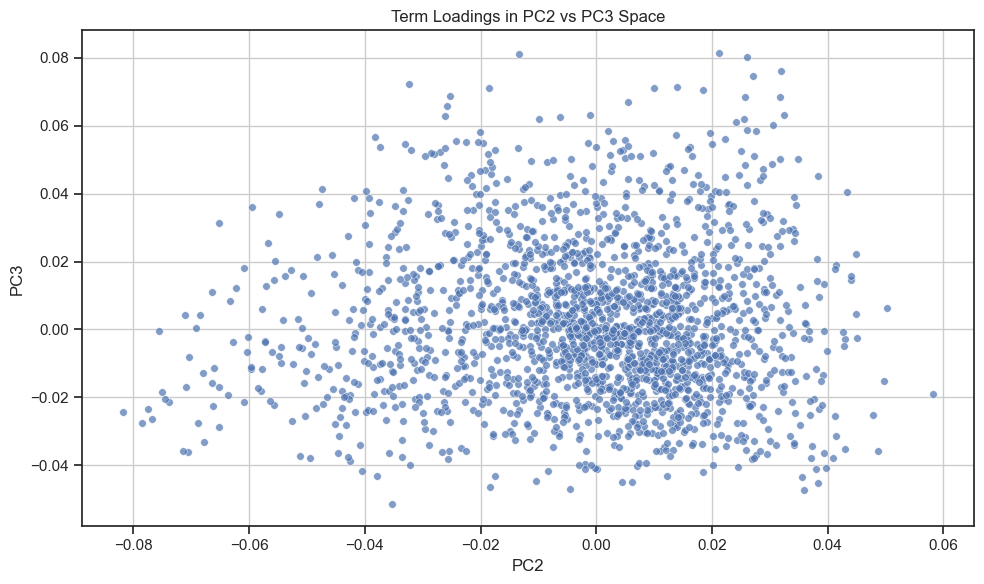

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=loadings.reset_index(),
    x='PC2',
    y='PC3',
    alpha=0.7,
    s=30)
plt.title("Term Loadings in PC2 vs PC3 Space")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_vis_2b.png", dpi=300)
plt.show()

## LDA

Chapter as bag

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [40]:
BAG = CHAP
BAG

['book_id', 'chap_num']

In [42]:
# CountVectorizer parameters
max_features = 4000
stop_words = 'english'

# LatentDirichletAllocation parameters
n_components = 20
max_iter = 5
learning_offset = 50.
random_state = 0

# Hyperparameters
n_words = 7

In [44]:
DOCS_chap = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(map(str,x)))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [46]:
DOCS_chap

doc_str
book_id chap_num                                                   
1       1         streets arm arm clerks leaps mud lady typists ...
        2         night movement salt smells case clothes bed br...
        3         morning sound chains heart deck castle hill an...
        4         morning clarissa anyone else deck air morning ...
        5         observations conclusion accidents sea course l...
...                                                             ...
4       4         party party street speaking time flow sound do...
        5         grey nurse knitting seat grey dress hands cham...
        6         nurse baby snored suddenness death soul lord s...
        7         awful sun hot things life way day notice boy s...
        8         tilt downstairs room cover chair moment silver...

[83 rows x 1 columns]

In [48]:
count_engine = CountVectorizer(max_features=max_features, stop_words='english')
count_model = count_engine.fit_transform(DOCS_chap.doc_str)
TERMS_chap = count_engine.get_feature_names_out()

VOCAB_chap = pd.DataFrame(index=TERMS_chap)
VOCAB_chap.index.name = 'term_str'

DTM_chap = pd.DataFrame(count_model.toarray(), index=DOCS_chap.index, columns=TERMS_chap)

In [50]:
VOCAB_chap['doc_count'] = DTM_chap.astype('bool').astype('int').sum()
DOCS_chap['term_count'] = DTM_chap.sum(1)

In [52]:
VOCAB_chap.sample(3)

,doc_count
term_str,
harm,11
impression,26
indifferently,4


In [54]:
lda_engine = LDA(n_components=n_components, max_iter=max_iter, learning_offset=learning_offset, random_state=random_state)

In [56]:
TNAMES_chap = [f"T{str(x).zfill(len(str(n_components)))}" for x in range(n_components)]

In [58]:
## Theta

lda_model = lda_engine.fit_transform(count_model)

THETA_chap = pd.DataFrame(lda_model, index=DOCS_chap.index)
THETA_chap.columns.name = 'topic_id'
THETA_chap.columns = TNAMES_chap

In [60]:
THETA_chap.sample(10).T.style.background_gradient(cmap="YlGnBu", axis=None)

In [62]:
## Phi

PHI_chap = pd.DataFrame(lda_engine.components_, columns=TERMS_chap, index=TNAMES_chap)
PHI_chap.index.name = 'topic_id'
PHI_chap.columns.name = 'term_str'

In [64]:
PHI_chap.T.sample(10).style.background_gradient(cmap="YlGnBu", axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19
term_str,,,,,,,,,,,,,,,,,,,,
rule,0.050000,1.050000,2.139414,0.050000,0.050000,0.050000,0.050000,0.050000,2.511741,0.050000,0.050000,0.050000,1.007458,0.050000,0.050000,1.589940,0.050000,0.050000,1.001448,0.050000
card,0.050000,0.050000,0.345504,0.050000,0.050000,1.045975,0.050000,0.050000,5.140899,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.118146,0.050000,0.050000,6.599476,0.050000
teapot,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,3.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
dash,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,2.050000,0.050000,0.050000,0.050000,1.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
moss,0.050000,0.050000,2.029051,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,1.070949,0.050000
section,0.050000,0.050000,2.969254,0.050000,0.050000,0.050000,0.050000,0.198663,5.606643,1.050000,1.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,1.425441,0.050000
colors,0.050000,0.050000,0.050250,0.050000,0.050000,0.050000,0.050000,0.050000,5.049750,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
emblem,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,1.050000,3.050000,0.050000
bitter,0.050000,0.050000,3.265617,0.050000,0.050000,0.050000,0.050000,0.050000,1.834383,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000


In [66]:
## Topics

TOPICS_chap = PHI_chap.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_words).reset_index().term_str))\
    .to_frame('top_terms')

In [68]:
TOPICS_chap.style

,top_terms
topic_id,
T00,harsh aback pride prime primeval principle principles
T01,mother life time book people men poet
T02,people time room things eyes way life
T03,harsh aback pride prime primeval principle principles
T04,harsh aback pride prime primeval principle principles
T05,people eyes women room window man face
T06,trees river boat bank deck tree forest
T07,moment time head way mind sense feeling
T08,people time life room moment way eyes


### SAVE TABLES TO FILES

count matrix, topics table, theta table, phi table

In [70]:
TOPICS_chap.to_csv('woolf-TOPIC.csv', index=True, header=True)
PHI_chap.to_csv('woolf-PHI.csv', index=True, header=True)
THETA_chap.to_csv('woolf-THETA.csv', index=True, header=True)
DTM_chap.to_csv('woolf-LDA_DTM.csv', index=True, header=True) # count matrix

In [72]:
# Apply PCA to THETA: using sklearn PCA here

from sklearn.decomposition import PCA

# Apply PCA to THETA
pca = PCA(n_components=5)
theta_pca = pca.fit_transform(THETA_chap)

# Create a DataFrame for plotting
THETA_PCA = pd.DataFrame(theta_pca, index=THETA_chap.index, columns=['PC0', 'PC1', 'PC2', 'PC3', 'PC4'])

In [74]:
# Compute mean topic weights across documents
topic_weights = THETA_chap.mean(axis=0)

# Get topic assignment per document (most likely topic)
THETA_chap['top_topic'] = THETA_chap.idxmax(axis=1)

# Merge with LIB metadata
THETA_PCA = THETA_PCA.join(THETA_chap['top_topic'])
THETA_PCA = THETA_PCA.reset_index().merge(LIB.reset_index(), on='book_id')

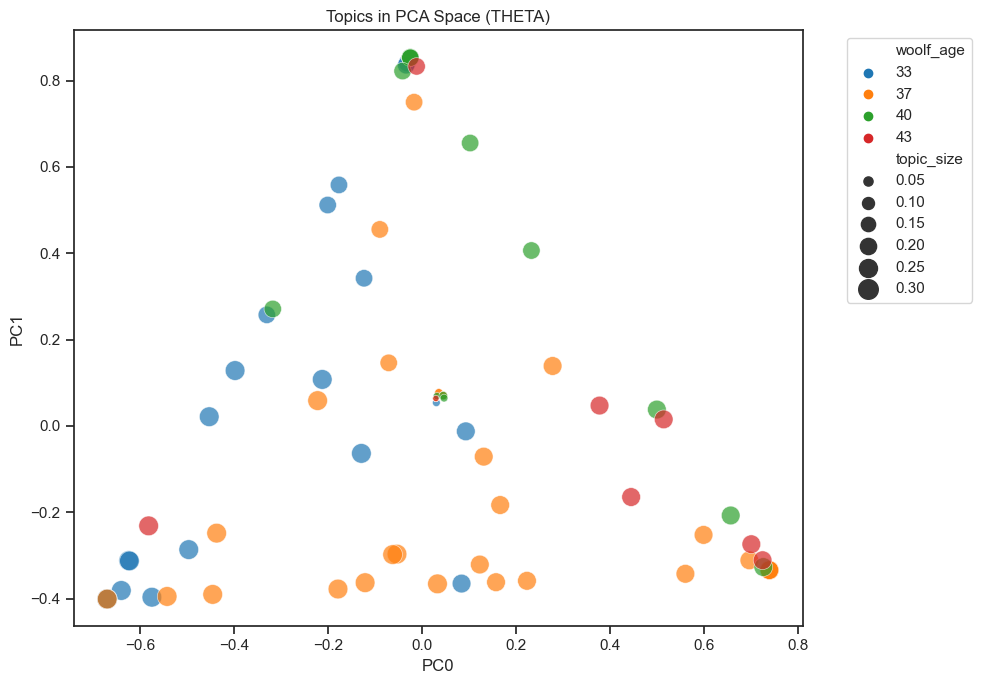

In [76]:
# Merge size back to THETA_PCA
THETA_PCA['topic_size'] = THETA_PCA['top_topic'].map(topic_weights)

# Scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=THETA_PCA,
    x='PC0',
    y='PC1',
    hue='woolf_age',
    size='topic_size',
    sizes=(20, 200),
    alpha=0.7,
    palette='tab10')
plt.title('Topics in PCA Space (THETA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("lda_pca.png", dpi=300)
plt.show()

In [78]:
# overwrite theta table file with added top topic feature
THETA_chap.to_csv('woolf-THETA.csv', index=True, header=True)

## RIFF

In [80]:
combined = THETA_chap.join(dcm)

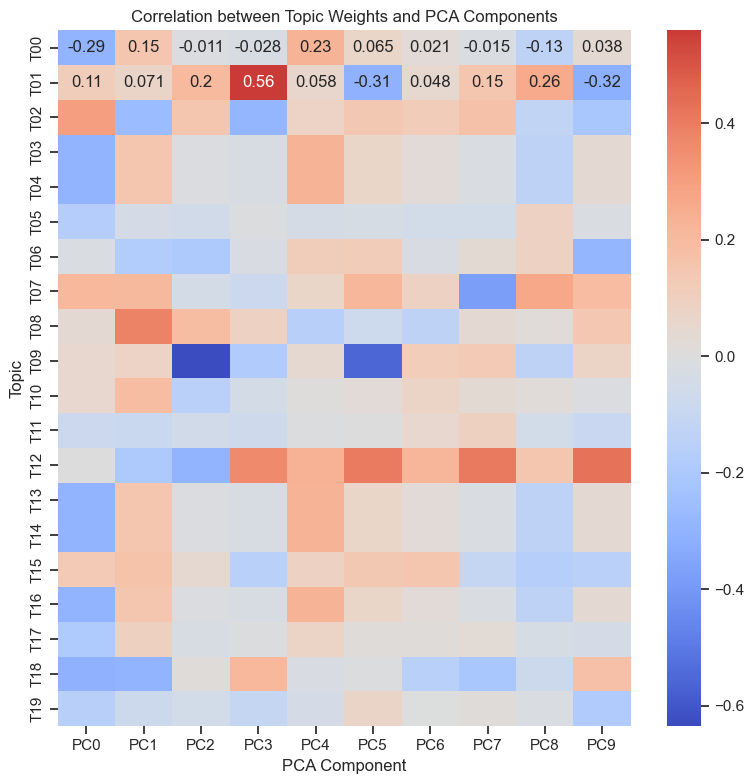

In [82]:
# Select only topic and PCA columns
topic_cols = [col for col in THETA_chap.columns if col.startswith('T')]
pca_cols = ['PC0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']

# Compute correlations
corr = combined[topic_cols + list(pca_cols)].corr().loc[topic_cols, pca_cols]

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Topic Weights and PCA Components')
plt.xlabel('PCA Component')
plt.ylabel('Topic')
plt.tight_layout()
plt.savefig("pca_lda_corr.png", dpi=300)
plt.show()

PC2 and T09 are correlated, PC3 and T01 as well. Can look into the top words for those components/topics. 

T09: night eyes arm moment light door time
PC2: region darkness globe swam recollection (neg)

T01: mother life time book people men poet
PC3: poet among mothers poets task books (pos)

## RIFF

In [84]:
# Add LIB metadata to each chapter via book_id

theta_with_meta = THETA_chap.join(LIB, on='book_id')

In [86]:
from sklearn.manifold import TSNE

# Extract topic columns
topic_cols = [col for col in theta_with_meta.columns if col.startswith('T')]
topic_vectors = theta_with_meta[topic_cols]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(topic_vectors)

# Add to DataFrame
theta_with_meta['tsne_1'] = tsne_result[:, 0]
theta_with_meta['tsne_2'] = tsne_result[:, 1]

In [88]:
DOC_SENT = pd.read_csv('woolf-DOC_SENT.csv').set_index(['book_id','chap_num'])
DOC_SENT = DOC_SENT.drop(columns=['raw_title', 'date', 'prot_sex'])

# Join sentiment scores into the theta/metadata table
theta_full = theta_with_meta.join(DOC_SENT, how='inner')

In [90]:
theta_full.head()

T00       T01       T02       T03       T04       T05  \
book_id chap_num                                                               
1       1         0.000055  0.000055  0.022842  0.000055  0.000055  0.976168   
        2         0.000054  0.000054  0.010077  0.000054  0.000054  0.000054   
        3         0.000058  0.000058  0.272104  0.000058  0.000058  0.000058   
        4         0.000058  0.000058  0.927782  0.000058  0.000058  0.000058   
        5         0.000103  0.000103  0.000103  0.000103  0.000103  0.000103   

                       T06       T07       T08       T09  ...    tsne_2  \
book_id chap_num                                          ...             
1       1         0.000055  0.000055  0.000055  0.000055  ... -3.213348   
        2         0.000054  0.000054  0.000054  0.000054  ...  1.350158   
        3         0.000058  0.000058  0.000058  0.000058  ...  1.716957   
        4         0.000058  0.000058  0.000058  0.000058  ...  3.712948   
        5         0.000103  0.000103  0.000103  0.000103  ... -1.914267   

                  anger_weighted  anticipation_weighted  disgust_weighted  \
book_id chap_num                                                            
1       1               0.011923               0.012112          0.007949   
        2               0.010581               0.014108          0.009096   
        3               0.008581               0.011977          0.010547   
        4               0.009774               0.015261          0.008745   
        5               0.012448               0.012102          0.010719   

                  fear_weighted  joy_weighted  sadness_weighted  \
book_id chap_num                                                  
1       1              0.015329      0.015897          0.016843   
        2              0.011324      0.022090          0.013366   
        3              0.012156      0.015731          0.014659   
        4              0.011831      0.018861          0.013032   
        5              0.015906      0.018326          0.013831   

                  surprise_weighted  trust_weighted  sentiment_weighted  
book_id chap_num                                                         
1       1                  0.006813        0.016276           -0.001703  
        2                  0.009467        0.019120            0.009282  
        3                  0.008223        0.020915            0.002860  
        4                  0.007202        0.019204            0.007202  
        5                  0.009682        0.016598            0.000000  

[5 rows x 40 columns]

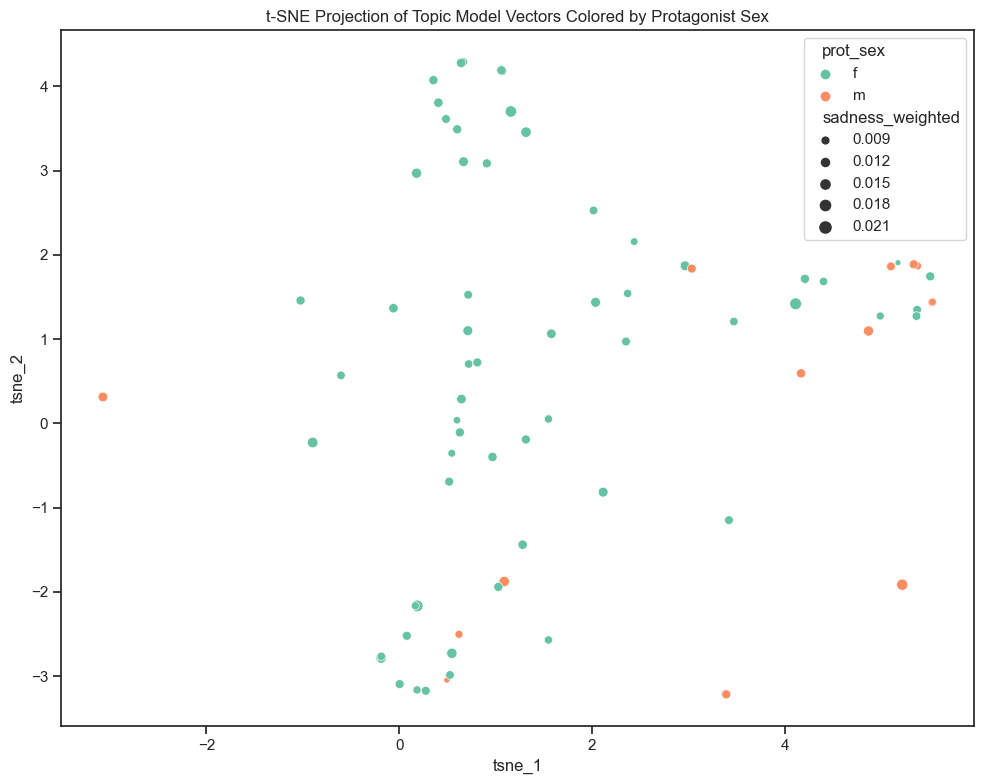

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=theta_full,
    x='tsne_1', y='tsne_2',
    hue='prot_sex',
    size='sadness_weighted',
    palette='Set2'
)
plt.title('t-SNE Projection of Topic Model Vectors Colored by Protagonist Sex')
plt.tight_layout()
plt.savefig("tsne_topic_models.png", dpi=300)
plt.show()